# Project 1: Assessing Population Dynamics in Pacific Small Island Developing States

### Adolphe Quetelet - Evan Anderson, Laure Ho, Jakob Mackanych, Noah Mujica, and Rania Nasser
#### EEP 153 - Population, Environment, and Development
#### February 13th, 2025

Climate change will have far-reaching global consequences, however, in the near future, its impacts will perhaps be nowhere as pronounced and devastating as in the Pacific. 

According to a report by the World Meteorological Organization, "A triple whammy of accelerating sea level rise, ocean warming and acidification is imperilling Pacific Islands, which face growing threats to their socioeconomic viability and indeed their very existence because of climate change" (1). The IPCC identifies these nations as the most vulnerable places in the world to climate change (2).

Pacific Small Island Developing States (PSIDS) or Pacific Small States (PSS) are a group of 14 developing nations: Cook Islands, Federated State of Micronesia, Fiji, Kiribati, Nauru, Niue, Palau, Papua New Guinea, Marshall Islands, Samoa, Solomon Islands, Tonga, Tuvalu, and Vanuatu (3). 

Increased severity of natural disasters and floods will have far-reaching impacts: agriculture, freshwater, tourism, industry, and ecosystems are and will further experience damages. Climate risk therefore poses safety and security risks to the people of PSS states (2).

**How might population and development data illuminate the problems, risks, and patterns associated with climate impacts in the Pacific?**

Using development data from the World Bank, we will see how climate change will impact these states and their population dynamics. We will also compare those dynamics to a developed nation.

![Example Image](https://static01.nyt.com/images/2023/11/11/multimedia/11oz-climate-vhpc/11oz-climate-vhpc-superJumbo.jpg)


Tuvalu's narrow coastline is being eaten away by rising sea levels. Source: [The New York Times.](https://www.nytimes.com/2023/11/11/world/australia/tuvalu-climate.html)

In [20]:
%pip install wbdata
%pip install iso3166
%pip install cufflinks
%pip install eep153_tools
%pip install plotly
%pip install geodatasets
%pip install geopandas
%pip install wbdata
%pip install geodatasets

import geodatasets
import geopandas as gpd
import wbdata
import pandas as pd
import math
from datetime import datetime
import iso3166
import plotly.offline as py
from scipy.optimize import newton
import plotly.graph_objs as go
import numpy as np
import cufflinks as cf
from matplotlib import animation as ani
cf.go_offline()
import geodatasets
import geopandas as gpd
from geodatasets import get_path
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67896 sha256=88c799b5d88d5c0af027632ad90d2f5902e9f2ff4b365f7494d71c59f8168fbd
  Stored in directory: /home/jovyan/.cache/pip/wheels/c3/bf/8f/afa0730b29e347e8c1071049f89748c1262e7a14a838820ae6
Successfully built cufflinks
Note: you may need to restart the kernel to use updated packages.
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated p

## Population Statistics Function

We begin by defining a function to easily access a population estimate given standard parameters.

In [ ]:
#Match World Bank age ranges to a given sex
def get_matching_indicators(age_range, sex):
    age_ranges = [f"{i:02d}{i+4:02d}" for i in range(0, 80, 5)] + ["80UP"]
    male_variables = {f"SP.POP.{age}.MA": f"Males {age}" for age in age_ranges}
    female_variables = {f"SP.POP.{age}.FE": f"Females {age}" for age in age_ranges}

    #Creates dictionary for sex variables
    variables = male_variables.copy()
    variables.update(female_variables)

    #Matches age to given sex, and includes "People"
    indicators = []
    for age in age_helper(age_range):
        if sex == "People":
            indicators.append(f"SP.POP.{age}.MA")
            indicators.append(f"SP.POP.{age}.FE")
        elif sex == "Males":
            indicators.append(f"SP.POP.{age}.MA")
        elif sex == "Females":
            indicators.append(f"SP.POP.{age}.FE")
    return indicators

#Converting given age range into World Bank ranges
def age_helper(age_range):
    lower_bound = 5 * (min(age_range) // 5)
    upper_bound = 5 * round(max(age_range) // 5)
    # To interpolate ages within a given age range, weigh the minimum and maximum given values out of the bins the World bank uses.
    
    age_groups = ["{:02}{:02}".format(i, i+4) for i in range(lower_bound, min(80, upper_bound+1), 5)]

    if upper_bound >= 80:
        age_groups.append("80UP")

        #80UP is a string that represents all ages above 80, which the World Bank groups into one large bin.

    return age_groups

#Create population function
def population(year, sex, age_range, place):
    current_year = datetime.now().year
    if not (1960 <= year <= current_year):
        raise ValueError("Please choose another year that is between 1960 and this year.")
    if sex not in ["People", "Males", "Females"]:
        raise ValueError("Please choose from the following 3 options: 'People', 'Males', 'Females'")

        #If input value is outside of the possible criterea, return error message to fix arguments.

    indicators = get_matching_indicators(age_range, sex)

    try:
        data = wbdata.get_dataframe({ind: ind for ind in indicators}, country = place, date = f"{year}-01-01")
        if data is None or data.empty:
            print("No available data.")
            return 0

        #Create proportions for the age ranges
        population_count = 0
        for ind in indicators:
            if not data[ind].isnull().iloc[0]:
                age_group = ind.split(".")[2]
                group_low = int(age_group[:2])

                if "UP" in age_group:
                    group_high = 200

                    #More than the oldest person ever alive.
                    
                else:
                    group_high = int(age_group[2:])

                group_pop = data[ind].iloc[0]

                overlap_low = max(group_low, age_range[0])
                overlap_high = min(group_high, age_range[1])

                pop_prop = (overlap_high - overlap_low + 1) / (group_high - group_low + 1)

                population_count += group_pop * pop_prop

        return int(population_count)
        
    except Exception as e:
        print(f"Error fetching requested data: {e}")
        return None

print(population(2022, "People", (10, 24), "USA"))

### Unit Tests

The following tests are designed to double-check our population function with common-sense ideas.

In [ ]:
#This is what I will be testing
print(population(2022, "People", (1, 100), "USA"))
print(population(2000, "Males", (13, 27), "AUS"))
print(population(1960, "Females", (20, 55), "WLD"))
print(population(2022, "People", (1,100), "PSS"))

# Unit Tests: Do
# Numbers grapped from printed amounts above (control) against our population function. The asserted numbers are purposefully less than what should be reality.

if __name__ == "__main__":
    assert population(year=2022, sex='People', age_range=(1, 100), place='USA') > 300000000, "Too few people!"
    assert population(year=2000, sex='Males', age_range=(13, 27), place='AUS') > 2000000, "Too few males!"
    assert population(year=1960, sex='Females', age_range=(20, 55), place='WLD') > 650000000, "Too few females!"
    assert population(year=2022, sex='People', age_range=(1, 100), place='PSS') > 2500000, "Too few people!"
    print("All tests passed!")

## Population Data Frames

A function that returns a pandas DataFrame indexed by Region or Country and Year, with columns giving counts of people in different age-sex groups.

In [ ]:
# Function to create a population DataFrame
def get_population_data(year, variables, gender, place_code):
    population_data = wbdata.get_dataframe(variables, country=place_code)
    population_data.index = population_data.index.astype(int)
    population_data.reset_index(inplace=True)
    population_data = population_data[population_data['date'] == year].melt(
        id_vars=["date"], var_name="age", value_name=gender
    )
    # Add place code 
    population_data['place'] = place_code
    population_data.set_index(['place', 'date'], inplace=True)
    return population_data

def population_df(year, sex, age_range, place_code='WLD'):
    age_ranges = age_helper(age_range)
    male_variables = {"SP.POP." + i + ".MA": "{}-{}".format(i[:2], i[2:]) for i in age_ranges}
    female_variables = {"SP.POP." + i + ".FE": "{}-{}".format(i[:2], i[2:]) for i in age_ranges}
    
    male_population = get_population_data(year, male_variables, 'male', place_code)
    female_population = get_population_data(year, female_variables, 'female', place_code)
    
    # Merge data based on selected sex
    if sex == 'male':
        df = male_population
    elif sex == 'female':
        df = female_population
    else:
        # Combine male and female data for total population
        df = male_population.merge(female_population, on="age").set_axis(male_population.index)
        df["total"] = df["female"] + df["male"]
    
    return df

In [ ]:
USA = population_df(year=(2020), sex='both', age_range=[0, 120], place_code='USA')

column_sum = USA['total'].sum()
int(column_sum)

if __name__ == "__main__":
    assert USA['total'].sum() > 250000000, "Too few people!"
    print ("Test passes")

#The USA should have more than 250 million people in 2020. If the total from dataframe is less than that, we've done something wrong.

In [ ]:
#Unit tests

## Kosovo did not exist in 1930 and should show no data.

Kosovo = population_df(year=(1930), sex='People', age_range=[0, 120], place_code='XK')
Kosovo

In [ ]:
# Now for the Pacific.

population_df(year=(2020), sex='male', age_range=[0, 50], place_code='TUV')

In [ ]:
population_df(year=(2020), sex='all', age_range=[0, 20], place_code='FJI')

## Population Pyramids

Now we can visualize the populations of our countries of interest by age-sex groups. For simplicity, we will use the age-sex groups already defined by the World Bank.

In [ ]:
import matplotlib.pyplot as plt  # For plotting

# Function to plot a population pyramid
def plot_population_pyramid(df, place):
    # Plotting population pyramid
    age_groups = df['age']
    fig, ax = plt.subplots(figsize=(10, 8))
    # Horizontal bar plot for males (positive) and females (negative)
    ax.barh(age_groups, df['male'], color='blue', label='Males')
    ax.barh(age_groups, -df['female'], color='red', label='Females')
    ax.set_xlabel('Population')
    ax.set_ylabel('Age Groups')
    ax.set_title(f'Population Pyramid for {place}')
    ax.legend()
    plt.show()

In [ ]:
world_pop = population_df(year=2022, sex='all', age_range=(0, 80), place_code='PSS')
plot_population_pyramid(world_pop, 'PSS')

The Pacific Small Island States Population Pyramid has a triangular shape, indicating a growing young population and a declining older population. This suggests high birth rates, high mortality rates, and low short life expectancy. 


In [ ]:
world_pop = population_df(year=2000, sex='all', age_range=(0, 80), place_code='FJI')
plot_population_pyramid(world_pop, 'FJI')

Fiji's Population Pyramid also has a somewhat triangular shape, indicating a growing young population and working population alongside a gradually declining older population. This suggests high birth rates, moderate mortality rates, and a relatively short life expectancy.

In [ ]:
world_pop = population_df(year=2022, sex='all', age_range=(0, 80), place_code='NZL')
plot_population_pyramid(world_pop, 'NZL')

The New Zealand Population Pyramid is somewhat rectangular, indicating a strong working-age population (30-49) and a steady young population. However, while the older population is gradually declining, it remains significant, suggesting a longer life expectancy and low mortality rates. 

In [ ]:
def plot_population_pyramid_over_time(years, place_code):
    """Plot population pyramids for multiple years on a single graph using Matplotlib."""
    fig, ax = plt.subplots(figsize=(10, 8))

    colors = ['yellow', 'orange', 'red', 'brown']
    for i, year in enumerate(years):
       
        df = population_df(year=year, sex='all', age_range=(0, 80), place_code=place_code)

        # age groups
        age_groups = df['age']

        # Plot males (positive values)
        ax.barh(age_groups, df['male'], color=colors[i], alpha=0.6, label=f'Males {year}')

        # Plot females (negative values)
        ax.barh(age_groups, -df['female'], color=colors[i], alpha=0.6, label=f'Females {year}')

    # labels and titles
    ax.set_xlabel('Population')
    ax.set_ylabel('Age Groups')
    ax.set_title(f'Population Pyramid Changes Over Time for {place_code}')
    ax.legend()

    plt.show()

    return ax

# Define years to visualize
years = [2020, 2000, 1980, 1960]

# Generate population pyramids for New Zealand over time
ax = plot_population_pyramid_over_time(years, 'PSS')

The population pyramid for the Pacific Small Island States (PSS) has maintained a triangular shape over time, indicating consistently high birth rates and a youthful population. While there is a slight widening in older age groups, the overall structure suggests persistently high fertility rates, shorter life expectancy, and slower demographic transition compared to more developed nations.

In [ ]:
plot_population_pyramid_over_time(years, 'FJI')

Fiji’s population pyramid over time maintains a triangular shape, reflecting high birth rates and a growing young population. While there is some expansion in older age groups, the gradual narrowing suggests moderate improvements in life expectancy but a continued need for healthcare and aging support policies.


In [ ]:
plot_population_pyramid_over_time(years, 'NZL')

New Zealand’s population pyramid over time shows a shift from a triangular to a more rectangular shape, indicating declining birth rates and an aging population. The expansion in older age groups and the narrowing at younger age groups suggest increased life expectancy, lower fertility rates, and a gradual demographic transition towards an aging society.


## Fertility and Mortality Rates

### Fertility Rates

In [ ]:
SOURCE1 = 14
indicators = wbdata.get_indicators(source = SOURCE1)

In [ ]:
variable_labels = {"SP.POP.TOTL":"Population, Total"}
PSS_pop = wbdata.get_dataframe(variable_labels, country="PSS",parse_dates=True)
PSS_pop.head()

In [ ]:
import seaborn as sea

countries = ["FJI", "SLB", "VUT", "WSM", "FSM", "KIR", "TON", "MHL", "PLW", "TUV", "NRU"]

variable_labels_TFRT = {"SP.DYN.TFRT.IN": "Fertility Rate"}

DYN_PSS_TFRT = wbdata.get_dataframe(variable_labels_TFRT, country=countries)
print(DYN_PSS_TFRT)

DYN_PSS_TFRT_cleaned = DYN_PSS_TFRT.dropna().reset_index()

In [ ]:
plt.figure(figsize=(12, 6))
sea.histplot(
    data=DYN_PSS_TFRT_cleaned, 
    x="Fertility Rate", 
    hue="country",  # Different colors for different countries
    bins=15, 
    kde=True, 
    palette="tab10",
    alpha=0.7
)

# Customizing the plot
plt.title("Distribution of Fertility Rates by Country")
plt.xlabel("Fertility Rate")
plt.ylabel("Weight")
plt.legend(title="Country", self=variable_labels_TFRT)
plt.show()

### Distributed histogram - fertility
 - The bars represent the count (or frequency) of fertility rates within specific ranges (bins)

 - The height of each bar represents how many fertility rates fall into that range
The lines overlaid on the bars represent key density estimate curves for each country.

 - KDE is used to estimate the probability distribution of fertility rates in a smooth, continuous way

 - Each country has a different color-coded KDE curve that shows the general distribution trend of fertility rates

### Interpretation
 - There is a peak around 3 to 5 fertility rate, meaning many countries have fertility rates in this range
 - Some fertility rates extend beyond 7 to 8, but these are less common

### Mortality Rates

In [ ]:
variable_labels_IMRT = {"SP.DYN.IMRT.IN": "Mortality Rate"}

DYN_PSS_IMRT = wbdata.get_dataframe(variable_labels_IMRT, country=countries)
print(DYN_PSS_IMRT)

DYN_PSS_IMRT_cleaned = DYN_PSS_IMRT.dropna().reset_index()

In [ ]:
plt.figure(figsize=(12, 6))
sea.histplot(
    data=DYN_PSS_IMRT_cleaned, 
    x="Mortality Rate", 
    hue="country",  # Different colors for different countries
    bins=15, 
    kde=True, 
    palette="tab10",
    alpha=0.7
)

# Customizing the plot
plt.title("Distribution of Mortality Rates by Country")
plt.xlabel("Mortality Rate")
plt.ylabel("Weight")
plt.legend(title="Country", label = variable_labels_IMRT)
plt.show()

### Distributed histogram - mortality
The bars represent the count (or frequency) of mortality rates within specific ranges (bins)
The height of each bar represents how many mortality rates fall into that range
KDE is used to estimate the probability distribution of mortality rates in a smooth, continuous way
Each country has a different color-coded KDE curve that shows the general distribution trend of mortality rates

### Interpretation
The peak near 20 suggests that many countries have relatively low mortality rates
A long tail on the right suggests that a smaller number of countries have very high mortality rates 


In [ ]:
Q1 = np.nanpercentile(DYN_PSS_IMRT, 25)
Q3 = np.nanpercentile(DYN_PSS_IMRT, 75)
IQR = Q3 - Q1

print(f"IQR: {IQR}")

In [ ]:
Q1 = np.nanpercentile(DYN_PSS_TFRT, 25)
Q3 = np.nanpercentile(DYN_PSS_TFRT, 75)
IQR = Q3 - Q1

print(f"IQR: {IQR}")

## Agricultural Supply

In [ ]:
from matplotlib.ticker import ScalarFormatter

#Plotting cereal production across various countries alongside their growth in population
#We will compare the graphs to see if it follows Malthus' theory
#We can also see how agricultural production differs across Pacific Island States
pd.options.plotting.backend = 'plotly'

#Create variables for Cereal Production and Population as a comparison
variable_labels = {
                "AG.PRD.CREL.MT":"Cereal Production (Metric Tons)",
                   "SP.POP.TOTL":"Total Population"
                  }

#We used these countries because they are Islands in the Pacific with data that go back to 1965. New Zealand acts as our developed counterfactual.
countries = ["PSS", "FJI", "SLB", "NZL"]

#Create dataframe that includes necessary variables
df1 = wbdata.get_dataframe(variable_labels, country = countries, parse_dates = True).dropna()

#Create two series to display cereal production and population
df1_cereal = df1["Cereal Production (Metric Tons)"].unstack(level="country").dropna()
df1_pop = df1["Total Population"].unstack(level="country").dropna()

pd.options.plotting.backend = 'matplotlib'

#Plot individual country comparisons
for country in df1_cereal.columns:
    fig, ax1 = plt.subplots(figsize=(12, 6)) #Configure for aesthetics
    ax2 = ax1.twinx()  #Create a second y-axis

    df1_cereal[country].plot(ax=ax1, marker="o", linewidth=2, label="Cereal Production", color='blue')
    df1_pop[country].plot(ax=ax2, marker="o", linewidth=2, alpha=0.7, label="Total Population", color='red')

    ax1.set_title(f"Cereal Production and Population in {country} Over Time")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Cereal Production (Metric Tons)", color='blue')
    ax2.set_ylabel("Total Population", color='red')

    #Get rid of scientific notation for each graph
    ax1.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax1.ticklabel_format(style="plain", axis="y")
    ax2.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax2.ticklabel_format(style="plain", axis="y")
    
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.show()

Cereal production across various Pacific Island States (Fiji, Solomon Islands), along with Pacific Islands accumulated, has generally decreased since 1990. At the same time, there has been a linear increase in population since the 60s. This directly contradicts Malthus' theory of geometric population versus arithmetic food growth: even when (at least domestic) food production in decreasing, population is increasing. Part of this phenomenon may be attributed to globalized food economies and import to the Pacific islands.

In [ ]:
#Plot graphs for food production, crop production, and livestock for different states
#Normalized to one year (2000)
#Compare production across different countries

#Set backend for initial data retrieval
pd.options.plotting.backend = 'plotly'

#Define necessary variables
vars = {
    "AG.PRD.FOOD.XD":"Food Production",
    "AG.PRD.CROP.XD":"Crop Production",
    "AG.PRD.LVSK.XD":"Livestock Production"
}

#Get countries with enough data for food, crop, and livestock indexes
places = ["AUS", "FJI", "SLB"]

#Retrieve new data
df2 = wbdata.get_dataframe(vars, country=places, parse_dates=True).dropna()

#Get 3 series
df2_food = df2["Food Production"].unstack(level="country")
df2_crop = df2["Crop Production"].unstack(level="country")
df2_livestock = df2["Livestock Production"].unstack(level="country")

#Normalize data to year 2000
base_year = "2000-01-01" #Uses string as per dataframe

def normalize(df2, base_year):
    """Normalize a dataframe by a base year."""
    if base_year in df2.index:
        return df2 / df2.loc[base_year]
    else:
        print(f"Warning: Base year {base_year} not found in dataset.")
        return df2

#Create new series baseed on normalization
df2_food_norm = normalize(df2_food, base_year)
df2_crop_norm = normalize(df2_crop, base_year)
df2_livestock_norm = normalize(df2_livestock, base_year)

#Set backend for plotting
pd.options.plotting.backend = 'matplotlib'

#Plot raw vs normalized data
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(22, 18))

plot_titles = [
    ("Food Production Over Time", df2_food_norm),
    ("Crop Production Over Time", df2_crop_norm),
    ("Livestock Production Over Time", df2_livestock_norm)
]

for i, (title, norm_data) in enumerate(plot_titles):
  
    #Normalized data plot
    norm_data.plot(ax=axes[i], marker="o", linewidth=2)
    axes[i].set_title(f"{title} (Normalized to 2000)")
    axes[i].set_xlabel("Year")
    axes[i].set_ylabel(f"{title} (Relative to 2000)")
    axes[i].grid(True, linestyle="--", alpha=0.5)
    axes[i].legend(title="Country", loc = "upper right")

plt.tight_layout()
plt.show()

Climate change is expected to have a significant impact on agriculture in these developing nations. Subsistence agriculture and cash-crop exports (bananas, sugar cane, etc) represent a large portion of island nations’ economies. Increased precipitation, strengthened cyclones, coastal flooding, and temperature variation are expected to harm soil fertility, destroy crops, and reduce near-shore fishing success.

## Geographic Visualizations with Geopandas

In [5]:
SOURCE = 40 
indicators = wbdata.get_indicators(source=SOURCE)
#indicators

In [6]:
variable_labels = {"SM.POP.NETM":"Net Migration"}
country_mapping = {"NZL":"New Zealand", "FJI": "Fiji", "SLB":"Solomon Islands"}
df = wbdata.get_dataframe(variable_labels, country=list(country_mapping.keys()), parse_dates=True)
df = df.reset_index()
df["ISO_A3"] = df["country"].map({v: k for k, v in country_mapping.items()})
df

,country,date,Net Migration,ISO_A3
0,Fiji,2023-01-01,-3289.0,FJI
1,Fiji,2022-01-01,-3557.0,FJI
2,Fiji,2021-01-01,-6008.0,FJI
3,Fiji,2020-01-01,-6008.0,FJI
4,Fiji,2019-01-01,-11873.0,FJI
...,...,...,...,...
187,Solomon Islands,1964-01-01,-1200.0,SLB
188,Solomon Islands,1963-01-01,-1129.0,SLB
189,Solomon Islands,1962-01-01,-1073.0,SLB
190,Solomon Islands,1961-01-01,-1016.0,SLB


In [7]:
countries = [c['id'] for c in wbdata.get_countries()]

In [8]:
shapefile_path = "/home/jovyan/Project 1/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"

gdf = gpd.read_file(shapefile_path)

ERROR 1: PROJ: proj_create_from_database: Open of /srv/conda/share/proj failed


In [9]:
df.reset_index(inplace=True)

In [10]:
wb_countries = wbdata.get_countries()

matching_columns = [col for col in gdf.columns if "ISO" in col]

In [11]:
merged_gdf = gdf.merge(df, on="ISO_A3", how="left")

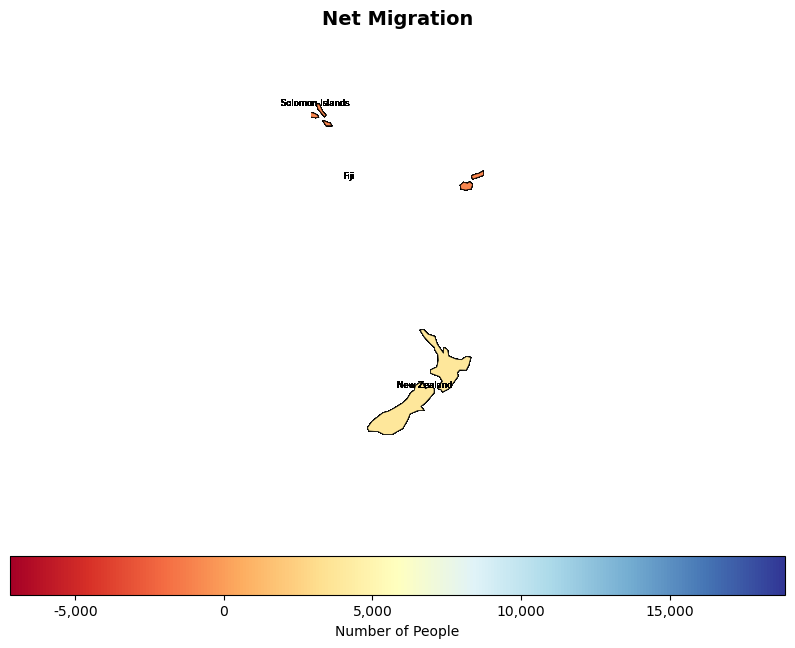

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

vmin = merged_gdf["Net Migration"].min()
vmax = merged_gdf["Net Migration"].max()

scaling_factor = 0.25
vmin, vmax = vmin * scaling_factor, vmax * scaling_factor 

merged_gdf.plot(column="Net Migration", cmap="RdYlBu", linewidth=0.5, edgecolor="black",
                         legend=True, legend_kwds={"label": "Number of People", "orientation": "horizontal"}, ax=ax,
               vmin=vmin, vmax=vmax
               )

ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.axis("off")

ax.set_xlim([160, 180]) 
ax.set_ylim([-50, 0])
ax.set_title("Net Migration", fontsize=14, fontweight="bold")

for idx, row in merged_gdf.iterrows():
    country_name = row["SOVEREIGNT"]
    if isinstance(country_name, str) and not pd.isna(row["Net Migration"]):
        ax.annotate(
            text=country_name,
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            xytext=(3, 3),
            textcoords="offset points",
            fontsize=6,
            ha='center'
        )

cbar = ax.get_figure().axes[-1]
cbar.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.show()

This visualization shows the net migration of three of our countries of interest. Through this visualization we can notice that islands who face a higher threat to climate change and sea level rise also contain a higher rate of net migration out of their countries. This negative net migration could be a result a other factors including economic opportunities or other factors. New Zealand contains a positive migration showing that more people were moving to this region than leaving in through 1960s and 2023. While the Solomon Islands and Fiji realized a negative net migration around -2,000 over this same time period.

In [13]:
variable_labels = {"SP.DYN.LE00.IN":"Total Life Expectancy"}
country_mapping = {"NZL":"New Zealand", "FJI": "Fiji", "SLB":"Solomon Islands"}
df = wbdata.get_dataframe(variable_labels, country=list(country_mapping.keys()), parse_dates=True)
df = df.reset_index()
df["ISO_A3"] = df["country"].map({v: k for k, v in country_mapping.items()})
df

,country,date,Total Life Expectancy,ISO_A3
0,Fiji,2023-01-01,NaN,FJI
1,Fiji,2022-01-01,68.312,FJI
2,Fiji,2021-01-01,67.114,FJI
3,Fiji,2020-01-01,67.924,FJI
4,Fiji,2019-01-01,67.893,FJI
...,...,...,...,...
187,Solomon Islands,1964-01-01,50.859,SLB
188,Solomon Islands,1963-01-01,50.049,SLB
189,Solomon Islands,1962-01-01,49.254,SLB
190,Solomon Islands,1961-01-01,48.434,SLB


In [14]:
countries = [c['id'] for c in wbdata.get_countries()]

In [15]:
shapefile_path = "/home/jovyan/Project 1/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"

gdf = gpd.read_file(shapefile_path)

In [16]:
df.reset_index(inplace=True)

In [17]:
wb_countries = wbdata.get_countries()

matching_columns = [col for col in gdf.columns if "ISO" in col] 

In [18]:
merged_gdf = gdf.merge(df, on="ISO_A3", how="left")

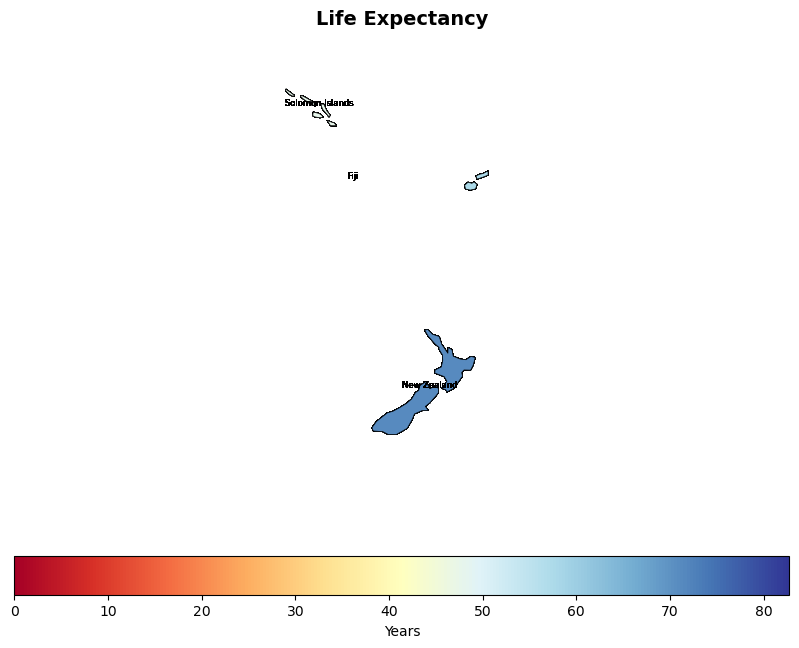

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

vmin = merged_gdf["Total Life Expectancy"].min()
vmax = merged_gdf["Total Life Expectancy"].max()
abs_max = max(abs(vmin), abs(vmax)) 
vmin, vmax = -abs_max+abs_max, abs_max

merged_gdf.plot(column="Total Life Expectancy", cmap="RdYlBu", linewidth=0.5, edgecolor="black",
                         legend=True, legend_kwds={"label": "Years", "orientation": "horizontal"}, ax=ax,
               vmin=vmin, vmax=vmax
               )

ax.set_xticks([])  
ax.set_yticks([])  
ax.set_frame_on(False) 
ax.axis("off")

ax.set_xlim([140, 200])
ax.set_ylim([-50, 0])
ax.set_title("Life Expectancy", fontsize=14, fontweight="bold")

for idx, row in merged_gdf.iterrows():
    country_name = row["SOVEREIGNT"]
    if isinstance(country_name, str) and not pd.isna(row["Total Life Expectancy"]):
        ax.annotate(
            text=country_name,
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            xytext=(3, 3),
            textcoords="offset points",
            fontsize=6,
            ha='center'
        )

cbar = ax.get_figure().axes[-1]
cbar.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.show()

This visualization shows the average life expectancy of our key areas of interest among Pacific Island nations. We can notice from this visualization that New Zealand has the highest life expectancy of all of the nations around 70 years. Among our countries of interest those with a negative migration also have a lower life expectancy. The Solomon Islands and Fiji have a lower life expectancy around 55 years on average. As the Solomon Islands and Fiji are more susceptible to climate change over time this could be one of the reasons that life expectancy is also lower in these regions among other things like healthcare access and education. As New Zealand is more resilient to the effects of climate change it does not greatly affect their life expectancy.


## Conclusions

 - Despite climate risk, PSS nations are experiencing upward population growth consistent with other developing countries.

 - Steep population pyramids, high fertility rates, low mortality rates
 - Population growth is slowing in these nations.
 - The population growth between 1980, 2000, and 2010 is narrowing: see the population pyramid!
 - Agricultural productivity in these nations has dramatically declined, and we don’t expect them to increase
   - Even though population has increased. This is likely because of more imports.


# Thank you!

## Citations

1) https://wmo.int/news/media-centre/climate-change-transforms-pacific-islands#:~:text=A%20triple%20whammy%20of%20accelerating,existence%20because%20of%20climate%20change.

2. https://research.fit.edu/media/site-specific/researchfitedu/coast-climate-adaptation-library/pacific-islands/micronesia/IFAD.--CC-Impacts.pdf

3) https://sdgs.un.org/statements/pacific-small-island-developing-states-psids-11347

All population data from World Bank Data. [Link](https://databank.worldbank.org/source/world-development-indicators)
.